In [108]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

import yfinance as yf

In [132]:
start_date = datetime(2021,6,1)
end_date = datetime(2021,12,31)
NVR = yf.download('NVR',start_date ,end_date)
Y = NVR['Adj Close'].values
NVR["Date"] = NVR.index
NVR = NVR[["Date", "Open", "High", 
             "Low", "Close", "Adj Close", "Volume"]]
NVR.reset_index(drop=True, inplace=True)
NVR.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-06-01,4925.330078,4925.330078,4817.879883,4841.020020,4841.020020,11700
1,2021-06-02,4841.000000,4841.000000,4785.899902,4795.490234,4795.490234,13800
2,2021-06-03,4755.609863,4793.990234,4696.120117,4747.069824,4747.069824,16600
3,2021-06-04,4785.000000,4827.430176,4702.000000,4810.000000,4810.000000,13400
4,2021-06-07,4824.450195,4824.450195,4760.910156,4808.509766,4808.509766,13700


In [133]:
 
def Kalman_Filter(param,*args):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = param[0]
 T = param[1]
 H = param[2]
 Q = param[3]
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 KF_Dens = np.zeros(S)
 for s in range(1,S):
  if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
  else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    Likelihood = sum(KF_Dens[1:-1]) # a loss function
    
    return Likelihood
          
def Kalman_Smoother(params, Y, *args):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1: 
    P_update[s] = 100
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
   else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[1:-1]
 return u_smooth







In [134]:
NVR['Typical_Price'] = NVR[['High','Low','Close']].mean(axis=1)


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/2022514766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVR['Typical_Price'] = NVR[['High','Low','Close']].mean(axis=1)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.1715011765691226
            Iterations: 28
            Function evaluations: 223
            Gradient evaluations: 28


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/182473007.py:11: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method='SLSQP', options={'xtol': 1e-8, 'disp': True})


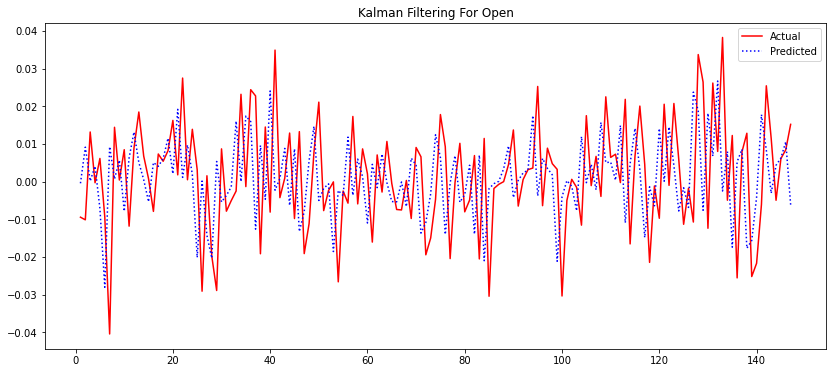

In [135]:
Y = NVR['Open'].values
Y = np.diff(np.log(NVR['Adj Close'].values))
T = Y.size;



mu = 1196;


param0 = np.array([0.9, 0.3, np.std(Y), np.std(Y)])
param_star = minimize(Kalman_Filter, param0, method='SLSQP', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T-1,T-1)
fig= plt.figure(figsize=(14,6))

#plt.plot(timevec, u,'r',timevec, Y[0:-1],'b:')

plt.plot(timevec, Y[0:-1],'r-', label='Actual')
plt.plot(timevec, u,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering For Open")
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.1715011765691226
            Iterations: 28
            Function evaluations: 223
            Gradient evaluations: 28


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/3157768599.py:11: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method='SLSQP', options={'xtol': 1e-8, 'disp': True})


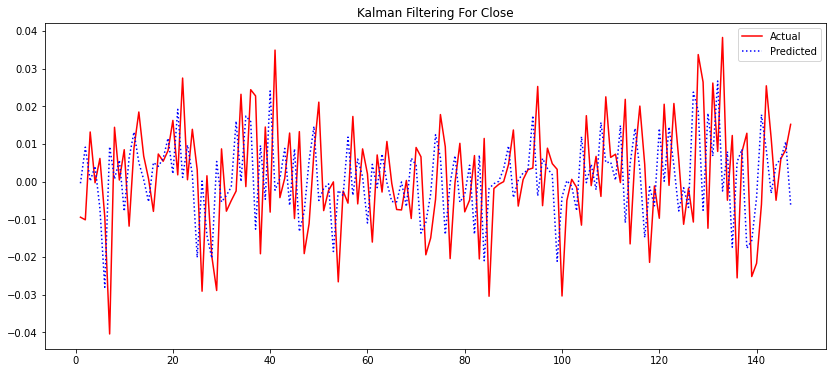

In [164]:
Y = NVR['Close'].values
Y = np.diff(np.log(NVR['Adj Close'].values))
T = Y.size;



mu = 1196;


param0 = np.array([0.9, 0.3, np.std(Y), np.std(Y)])
param_star = minimize(Kalman_Filter, param0, method='SLSQP', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T-1,T-1)
fig= plt.figure(figsize=(14,6))

#plt.plot(timevec, u,'r',timevec, Y[0:-1],'b:')

plt.plot(timevec, Y[0:-1],'r-', label='Actual')
plt.plot(timevec, u,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering For Close")
plt.show()

In [174]:
NVR['Date'][146]

0     2021-06-01
1     2021-06-02
2     2021-06-03
3     2021-06-04
4     2021-06-07
         ...    
141   2021-12-20
142   2021-12-21
143   2021-12-22
144   2021-12-23
145   2021-12-27
Name: Date, Length: 146, dtype: datetime64[ns]

In [168]:
type(NVR['Date'])

pandas.core.series.Series

In [175]:
results = pd.DataFrame({'Actual': list(Y[0:-2]),
                  'Predicted' : list(u[0:-1]),
                  'Date':NVR['Date'][:146],
                  'Open':NVR['Open'][:146],
                  'Close':NVR['Close'][:146]
                       })

In [176]:
results.set_index('Date',inplace = True)
results.tail(10)

,Actual,Predicted,Open,Close
Date,,,,
2021-12-13,0.007945,0.008580,5935.000000,5785.899902
2021-12-14,0.012832,-0.017701,5744.990234,5832.049805
2021-12-15,-0.025202,-0.015657,5839.299805,5907.370117
2021-12-16,-0.021685,-0.004151,5890.500000,5760.350098
2021-12-17,-0.006057,0.017783,5752.270020,5636.779785
2021-12-20,0.025431,0.008370,5578.819824,5602.740234
2021-12-21,0.011475,-0.003101,5642.830078,5747.049805
2021-12-22,-0.004958,0.004329,5755.100098,5813.379883
2021-12-23,0.006108,0.006275,5826.669922,5784.629883


In [177]:
dif = pd.DataFrame({'Actual':list(Y),
                     'Predicted':list(u)})

ValueError: All arrays must be of the same length

In [178]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        
    else:
        action.append('Sell at Open')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
    print('\n')
        

0 Sell at Open 9850.66 - 2 317
0 Buy Back at Close 9999.04 0


1 Buy at Open 9682.0 2 408
1 Sell at Close 9998.98 0


2 Buy at Open 9511.22 2 504
2 Sell at Close 9998.14 0


3 Sell at Open 9570.0 - 2 378
3 Buy Back at Close 9998.0 0


4 Sell at Open 9648.9 - 2 380
4 Buy Back at Close 9997.02 0


5 Sell at Open 9636.9 - 2 320
5 Buy Back at Close 9996.26 0


6 Buy at Open 9703.6 2 410
6 Sell at Close 9995.9 0


7 Buy at Open 9575.6 2 790
7 Sell at Close 9995.88 0


8 Sell at Open 9250.0 - 2 656
8 Buy Back at Close 9995.58 0


9 Sell at Open 9308.0 - 2 652
9 Buy Back at Close 9995.48 0


10 Sell at Open 9348.7 - 2 572
10 Buy Back at Close 9994.96 0


11 Buy at Open 9437.84 2 682
11 Sell at Close 9994.16 0


12 Sell at Open 9300.0 - 2 599
12 Buy Back at Close 9994.1 0


13 Sell at Open 9352.36 - 2 423
13 Buy Back at Close 9993.28 0


14 Sell at Open 9561.24 - 2 357
14 Buy Back at Close 9992.38 0


15 Buy at Open 9660.0 2 349
15 Sell at Close 9991.54 0


16 Buy at Open 9610.0 2 424
16 Sell 

In [179]:
results['Amount'] = list(Amount)

In [180]:
results['Returns'] = results['Amount'].pct_change()

In [181]:
mean_returns = results['Returns'].mean()
sd = results['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(878)*(mean_returns)/sd
Sharpe_Ratio

0.0058881488823341165 0.0820574309612814


2.1262196357255347

# A good model should have an RMSE value less than 180.


In [182]:
rmse = sqrt(mean_squared_error(results['Actual'],results['Predicted']))
rmse

0.01788332383698369